# Introduction to Natural Language Processing with fastText
In this notebook we will discuss what is Natural Language Processing (NLP) and how to easily implement several projects using the library [fastText](https://github.com/facebookresearch/fastText). fastText is implemented in C++, however, there is a python wrapper, [fastText.py](https://github.com/salestock/fastText.py), that we are going to use in this notebook.

In [1]:
#Load all libraries
import os,sys  
import pandas as pd
import numpy as np
import fasttext
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
try:
    from html import unescape  # python 3.4+
except ImportError:
    try:
        from html.parser import HTMLParser  # python 3.x (<3.4)
    except ImportError:
        from HTMLParser import HTMLParser  # python 2.x
    unescape = HTMLParser().unescape

print(sys.version)

3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


## Text classification
The first task will be to perform text classification dataset DBPedia, which can be accessed [here](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M). The dataset consists of text descriptions of 14 different classes. The training set contains 560000 reviews and the test contains 70000. 

In [2]:
#Load train set
train_file = 'dbpedia_train.csv'
df = pd.read_csv(train_file, header=None, names=['class','name','description'])

#Load test set
test_file = 'dbpedia_test.csv'
df_test = pd.read_csv(test_file, header=None, names=['class','name','description'])

#Mapping from class number to class name
class_dict={
1:'Company',
2:'EducationalInstitution',
3:'Artist',
4:'Athlete',
5:'OfficeHolder',
6:'MeanOfTransportation',
7:'Building',
8:'NaturalPlace',
9:'Village',
10:'Animal',
11:'Plant',
12:'Album',
13:'Film',
14:'WrittenWork'
}
df['class_name'] = df['class'].map(class_dict)
df.head()

,class,name,description,class_name
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...,Company
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...,Company
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...,Company
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...,Company
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...,Company


In [3]:
#df.describe().transpose()
desc = df.groupby('class')
desc.describe().transpose()

class           1                                                             \
             count unique                                                top   
class_name   40000      1                                            Company   
description  40000  39996   MegaPath Corporation—headquartered in Pleasan...   
name         40000  40000                                  Lohmann (company)   

class                  2          \
              freq  count unique   
class_name   40000  40000      1   
description      2  40000  39992   
name             1  40000  40000   

class                                                                     3   \
                                                           top   freq  count   
class_name                              EducationalInstitution  40000  40000   
description   Lakshmi Narain College of Technology (LNCT) i...      2  40000   
name                                Lakeland Community College      1  40000   

class               ...                                                   12  \
            unique  ...                                                  top   
class_name       1  ...                                                Album   
description  40000  ...     Before Smile Empty Soul became Smile Empty So...   
name         40000  ...                                We Deserve Much Worse   

class                  13         \
              freq  count unique   
class_name   40000  40000      1   
description      2  40000  40000   
name             1  40000  40000   

class                                                                     14  \
                                                           top   freq  count   
class_name                                                Film  40000  40000   
description   Hamlet is a 1948 British film adaptation of W...      1  40000   
name                                         Babul (1950 film)      1  40000   

class                                                                         
            unique                                                top   freq  
class_name       1                                        WrittenWork  40000  
description  39984   Tom Clancy's Net Force Explorers or Net Force...     15  
name         40000                                The Supernaturalist      1  

[3 rows x 56 columns]

The next step is to treat the data. As of today, the python wrapper of fastText doesn't allow dataframes or iterators as inputs to their functions (however, they are [working on it](https://github.com/salestock/fastText.py/issues/78). We have to create an intermediate file. This intermediate file doesn't have commas, non-ascii characters and everything is lowercase. The changes are based on [this script](https://github.com/facebookresearch/fastText/blob/a88344f6de234bdefd003e9e55512eceedde3ec0/classification-example.sh#L17).

In [4]:
def clean_dataset(dataframe, shuffle=False, encode_ascii=False, clean_strings = False, label_prefix='__label__'):
    # Transform train file
    df = dataframe[['name','description']].apply(lambda x: x.str.replace(',',' '))
    df['class'] = label_prefix + dataframe['class'].astype(str) + ' '
    if clean_strings:
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('"',''))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('\'',' \' '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('.',' . '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('(',' ( '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace(')',' ) '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('!',' ! '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('?',' ? '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace(':',' '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace(';',' '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.lower())
    if shuffle:
        from sklearn.utils import shuffle
        df = shuffle(df).reset_index(drop=True)
        #df.sample(frac=1).reset_index(drop=True)
    if encode_ascii :
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8'))
    df['name'] = ' ' + df['name'] + ' '
    df['description'] = ' ' + df['description'] + ' '
    return df

In [9]:
%%time
# Transform datasets
df_train_clean = clean_dataset(df, True, False)
df_test_clean = clean_dataset(df_test, False, False)

# Write files to disk
train_file_clean = 'dbpedia.train'
df_train_clean.to_csv(train_file_clean, header=None, index=False, columns=['class','name','description'] )

test_file_clean = 'dbpedia.test'
df_test_clean.to_csv(test_file_clean, header=None, index=False, columns=['class','name','description'] )

CPU times: user 9.83 s, sys: 400 ms, total: 10.2 s
Wall time: 10.3 s


Once the dataset is cleaned, the next step is to train the classifier. 

In [10]:
%%time
# Train a classifier
output_file = 'dp_model'
classifier = fasttext.supervised(train_file_clean, output_file, label_prefix='__label__')

CPU times: user 1min 26s, sys: 2 s, total: 1min 28s
Wall time: 20.4 s


Once the model is trained, we can test its accuracy. We can obtain the [percision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) of the model. High precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

In [11]:
%%time
# Evaluate classifier
result = classifier.test(test_file_clean)
print('P@1:', result.precision)
print('R@1:', result.recall)
print ('Number of examples:', result.nexamples)

P@1: 0.9836
R@1: 0.9836
Number of examples: 70000
CPU times: user 568 ms, sys: 0 ns, total: 568 ms
Wall time: 568 ms


The next step is to check how the model works with real sentences.

In [13]:
sentence1 = ['Picasso was a famous painter born in Malaga, Spain. He revolutionized the art in the 20th century.']
labels1 = classifier.predict(sentence1)
class1 = int(labels1[0][0])
print("Sentence: ", sentence1[0])
print("Label: %d; label name: %s" %(class1, class_dict[class1]))

sentence2 = ['One of my favourite tennis players in the world is Rafa Nadal.']
labels2 = classifier.predict_proba(sentence2)
class2, prob2 = labels2[0][0] # it returns class2 as string
print("Sentence: ", sentence2[0])
print("Label: %s; label name: %s; certainty: %f" %(class2, class_dict[int(class2)], prob2))

sentence3 = ['Say what one more time, I dare you, I double-dare you motherfucker!']
number_responses = 3
labels3 = classifier.predict_proba(sentence3, k=number_responses)
print("Sentence: ", sentence3[0])
for l in range(number_responses):
    class3, prob3 = labels3[0][l]
    print("Label: %s; label name: %s; certainty: %f" %(class3, class_dict[int(class3)], prob3))


Sentence:  Picasso was a famous painter born in Malaga, Spain. He revolutionized the art in the 20th century.
Label: 3; label name: Artist
Sentence:  One of my favourite tennis players in the world is Rafa Nadal.
Label: 4; label name: Athlete; certainty: 0.931641
Sentence:  Say what one more time, I dare you, I double-dare you motherfucker!
Label: 12; label name: Album; certainty: 0.554687
Label: 14; label name: WrittenWork; certainty: 0.263672
Label: 7; label name: Building; certainty: 0.056641


The model predicts sentence 1 as `Artist`, which is correct. Sentence 2 is also predicted correctly. This time we used the function `predict_proba` that retruns the certainty of the prediction as a probability. Finally, sentence 3 was not correctly classified. The correct label would be `Film`, since the sentence is from famous scene of a very good film. If by any chance, you don't know [what I'm talking about](https://www.youtube.com/watch?v=xwT60UbOZnI), well, please put your priorities in order. Stop reading this notebook, go to see Pulp Fiction, and then come back to keep learning NLP :-)

## Sentiment Analysis
Sentiment analysis is one of the most important use cases in text classification. The objective is to classify a piece of text into positive, negative and, in some cases, neutral. This is extensively used by brands to understand the perception their customers. Sentiment analysis can influence marketing campaigns, generate leads, plan product development or improeve customer service.  

In our notebook, we will use the Amazon polarity dataset, which contains 3.6 million reviews in the train set and 400.000 reviews in the test set. The reviews are positive, 1, or negative, 2. The dataset can be found [here](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M). 

The first step is to prepare the dataset for the algorithm format.

In [14]:
%%time
#Load train set
train_file = 'amazon_review_polarity_train.csv'
df_sentiment_train = pd.read_csv(train_file, header=None, names=['class','name','description'])

#Load test set
test_file = 'amazon_review_polarity_test.csv'
df_sentiment_test = pd.read_csv(test_file, header=None, names=['class','name','description'])

# Transform datasets
df_train_clean = clean_dataset(df_sentiment_train, True, False)
df_test_clean = clean_dataset(df_sentiment_test, False, False)

# Write files to disk
train_file_clean = 'amazon.train'
df_train_clean.to_csv(train_file_clean, header=None, index=False, columns=['class','name','description'] )

test_file_clean = 'amazon.test'
df_test_clean.to_csv(test_file_clean, header=None, index=False, columns=['class','name','description'] )

CPU times: user 1min 38s, sys: 5.48 s, total: 1min 43s
Wall time: 2min 43s


Once we have the data, let's train the classifier. This time instead of the default parameters we are going to use those used in the [fastText paper](https://arxiv.org/abs/1607.01759).

In [15]:
%%time
# Parameters
dim=10
lr=0.1
epoch=5
min_count=1
word_ngrams=2
bucket=10000000
thread=12
label_prefix='__label__'

# Train a classifier
output_file = 'amazon_model'
classifier = fasttext.supervised(train_file_clean, output_file, dim=dim, lr=lr, epoch=epoch,
                                 min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                 thread=thread, label_prefix=label_prefix)

CPU times: user 9min 31s, sys: 13.1 s, total: 9min 44s
Wall time: 1min 43s


Now let's evaluate the results

In [16]:
%%time
# Evaluate classifier
result = classifier.test(test_file_clean)
print('P@1:', result.precision)
print('R@1:', result.recall)
print ('Number of examples:', result.nexamples)

P@1: 0.941605
R@1: 0.941605
Number of examples: 400000
CPU times: user 5.73 s, sys: 264 ms, total: 5.99 s
Wall time: 5.97 s


Finally, let's evaluate some sentences

In [34]:
class_dict={
    1:"Negative",
    2:"Positive"
}

sentence1 = ["The product design is nice but it's working as expected"]
labels1 = classifier.predict_proba(sentence1)
class1, prob1 = labels1[0][0] # it returns class as string
print("Sentence: ", sentence1[0])
print("Label: %s; label name: %s; certainty: %f" %(class1, class_dict[int(class1)], prob1))

sentence2 = ["I bought the product a month ago and it was working correctly. But now is not working great"]
labels2 = classifier.predict_proba(sentence2)
class2, prob2 = labels2[0][0] # it returns class as string
print("Sentence: ", sentence2[0])
print("Label: %s; label name: %s; certainty: %f" %(class2, class_dict[int(class2)], prob2))

Sentence:  The product design is nice but it's working as expected
Label: 2; label name: Positive; certainty: 0.986328
Sentence:  I bought the product a month ago and it was working correctly. But now is not working great
Label: 1; label name: Negative; certainty: 0.871094


We can use a tweet as the text input. Twitter has a [REST API](https://dev.twitter.com/rest/public) that allows you to interact with all their data. However, everything from that API requires authentication (an example can be found in this [Twitter bot](https://github.com/miguelgfierro/twitter_bot) I made). Instead, we can parse the title of the tweet url, which contains the text of the tweet.

In [62]:
# Get twitter data
url = "https://twitter.com/miguelgfierro/status/805827479139192832"
response = urlopen(url).read()
title = str(response).split('<title>')[1].split('</title>')[0]
print(title)

# Format tweet
tweet = unescape(title)
print(tweet)

# Classify tweet
label_tweet = classifier.predict_proba([tweet])
class_tweet, prob_tweet = label_tweet[0][0]
print("Label: %s; label name: %s; certainty: %f" %(class_tweet, class_dict[int(class_tweet)], prob_tweet))

Miguel G-Fierro on Twitter: &quot;Today at @Microsoft we had a demo of the hololens. It is one of the most spectacular things I&#39;ve seen in my life&quot;
Miguel G-Fierro on Twitter: "Today at @Microsoft we had a demo of the hololens. It is one of the most spectacular things I've seen in my life"
Label: 2; label name: Positive; certainty: 0.998047


## Word representations
We can also use fastText to lean word vectors. This is way to represent words in a multidimemsional spaces, where each word has a coordinate. Similar words will be clustered in a specific region of this multidimensional space. 

As an example we are going to download the English Wikipedia 9 dataset: [enwik9](http://mattmahoney.net/dc/enwik9.zip). The data is UTF-8 encoded XML consisting primarily of English text. enwik9 contains 243,426 article titles, of which 85,560 are #REDIRECT to fix broken links, and the rest are regular articles.  

We can use the script `wikifil.pl` by [Matt Mahoney](http://mattmahoney.net/dc/textdata.html) to clean the data. Thi script filter Wikipedia XML dumps to "clean" text consisting only of lowercase letters (a-z, converted from A-Z), and spaces (never consecutive).  All other characters are converted to spaces.  Only text which normally appears in the web browser is displayed.  Tables are removed.  Image captions are preserved.  Links are converted to normal text.  Digits are spelled out. 

In [3]:
wiki_dataset_original = 'enwik9'
wiki_dataset = 'text9'
os.system("perl wikifil.pl " +  wiki_dataset_original + " > " + wiki_dataset)

0

Let's compute the Skipgram model of the dataset. We will obtain a for each word of 300 dimensions. 

In [2]:
%%time
# Learn the word representation using skipgram model
output_skipgram = 'skipgram'
if os.path.isfile(output_skipgram + '.bin'):
    skipgram = fasttext.load_model(output_skipgram + '.bin')
else:
    skipgram = fasttext.skipgram(wiki_dataset, output_skipgram, lr=0.02, dim=50, ws=5,
        epoch=1, min_count=5, neg=5, loss='ns', bucket=2000000, minn=3, maxn=6,
        thread=4, t=1e-4, lr_update_rate=100)
print(np.asarray(skipgram['king'])

CPU times: user 756 ms, sys: 1.7 s, total: 2.45 s
Wall time: 2min 57s


Since each word is represented in a multidimensional space, we can compute the similarity between words. The difference between king and queen will be smaller than between king and woman. Make sense right. At the same time the difference between man and woman will be smaller than king and woman. 

With word representations we are able to map from words to numerical values. What we are doing in fact is to featurize the words. The feautures can be used in different algorithms to learn the meaning of a text.

In [3]:
print("Number of words in the model: ", len(skipgram.words))

# Get the vector of some word
Droyals = np.sqrt(pow(np.asarray(skipgram['king']) - np.asarray(skipgram['queen']), 2)).sum()
print(Droyals)
Dpeople = np.sqrt(pow(np.asarray(skipgram['king']) - np.asarray(skipgram['woman']), 2)).sum()
print(Dpeople)
Dpeople2 = np.sqrt(pow(np.asarray(skipgram['man']) - np.asarray(skipgram['woman']), 2)).sum()
print(Dpeople2)

53.3997482372
70.4276856487
43.3500340882


In [ ]:
targets = ['man','woman','king','queen','cat','dog','bird','squirrel']
X_train=[]
for w in targets:
    X_train.append(skipgram[w])
X_train = np.asarray(X_train)

In [51]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=500, verbose=2).fit_transform(X_train)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 8 / 8
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Iteration 25: error = 0.0000001, gradient norm = 0.0000000
[t-SNE] Iteration 25: gradient norm 0.000000. Finished.
[t-SNE] Iteration 50: error = 0.0000001, gradient norm = 0.0000000
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 0.000000
[t-SNE] Iteration 75: error = 0.0000001, gradient norm = 0.0000000
[t-SNE] Iteration 75: gradient norm 0.000000. Finished.
[t-SNE] Error after 75 iterations: 0.000000


Populating the interactive namespace from numpy and matplotlib


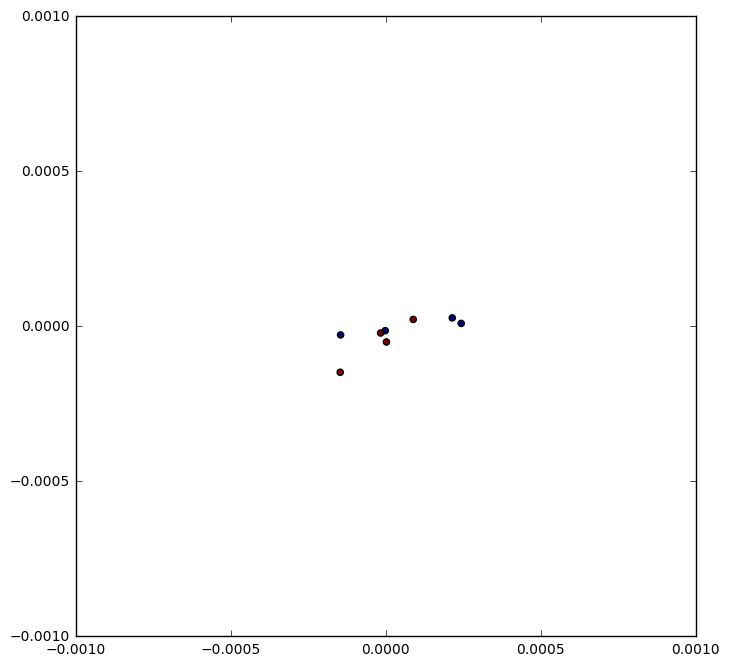

In [60]:
%pylab inline
classes = [x for x in range(len(targets))]
classes = [1,1,1,1,2,2,2,2]

fig = figure(figsize=(8, 8))
xlim(-0.001, 0.001)
ylim(-0.001, 0.001)
#ax = axes(frameon=False)
setp(ax, xticks=(), yticks=())
scatter(X_embedded[:, 0], X_embedded[:, 1], c=classes)